In [334]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import random

In [288]:
# config
base = "spotify_million_playlist_dataset"
pickles = base + "/pickles"

# full dataset
dataset_path = base + "/data"
pickled_graph = pickles + "/G.pkl"
pickled_dataset = pickles + "/dataset.pkl"

# example dataset (override above)
dataset_path = base + "/example"
pickled_graph = pickles + "/G_example.pkl"
pickled_dataset = pickles + "/dataset_example.pkl"

# deepsnap datasets
dataset_train, dataset_val, dataset_test = pickle.load(open(pickled_dataset, 'rb'))


In [396]:
def get_neigh_of_edge_type(G, edge_type, node):
    return [n for n in G.neighbors(node) if G[node][n]['edge_type'] == edge_type]

def top_n_by_followers(G, n, node_type='playlist'):
  # get all nodes of type playlist
  playlists = [node for node in G.nodes(data=True) if node[1]['node_type'] == node_type]
  return sorted(playlists, key=lambda x:'num_followers' in x[1] and x[1]['num_followers'], reverse=True)[:n]

def get_smart_playlist_subset(G, playlists_to_keep):
    keep_nodes = set()
    for node in playlists_to_keep:
        keep_nodes.add(node[0])
        tracks = get_neigh_of_edge_type(G, 'track-playlist', node[0])
        artists_and_albums = []

        for track in tracks:
            artists_and_albums += get_neigh_of_edge_type(G, 'track-artist', track)
            artists_and_albums += get_neigh_of_edge_type(G, 'track-album', track)
        
        keep_nodes = keep_nodes.union(set(tracks))
        keep_nodes = keep_nodes.union(set(artists_and_albums))
    return keep_nodes

G1 has 1518 nodes


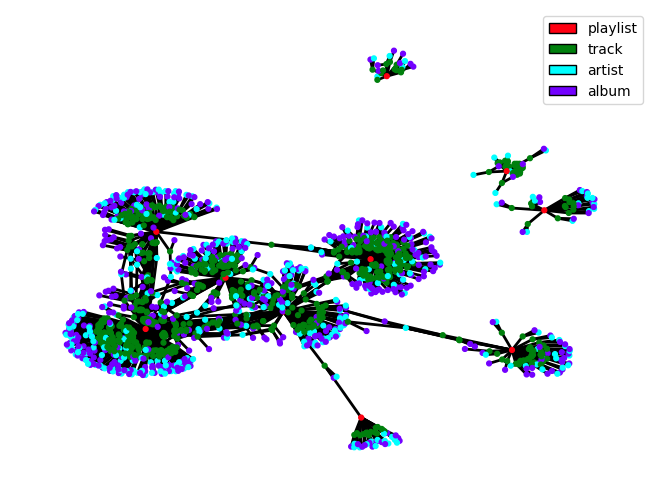

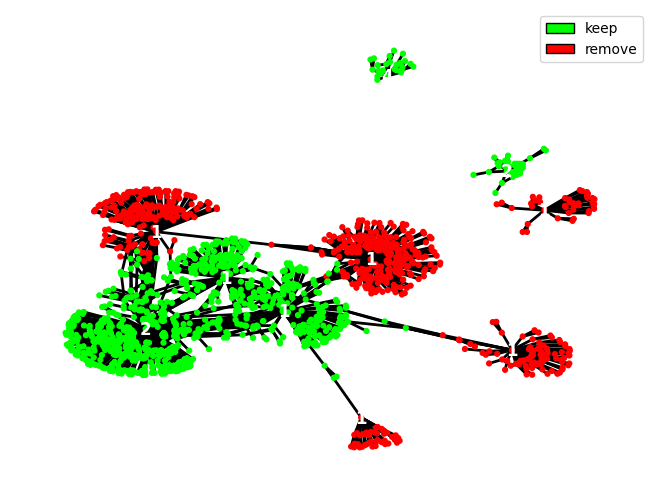

In [398]:
# visualize pruning
G = pickle.load(open(pickled_graph, 'rb'))

random_playlists = random.sample([node for node in G.nodes(data=True) if node[1]['node_type'] == 'playlist'], 10)
G1 = G.subgraph(get_smart_playlist_subset(G, random_playlists))

print(f"G1 has {len(G1.nodes)} nodes")

keep_nodes = get_smart_playlist_subset(G1, top_n_by_followers(G1, 5))
pos = nx.spring_layout(G1)

color_map = {'playlist': (1, 0, 17/255), 'track': (0, 0.5, 13/255), 'artist':(0, 1, 1), 'album':(115/255, 0, 1)}
node_color = [color_map[attr['node_type']] for (id, attr) in G1.nodes(data=True)]
labels = {id:attr['node_type'][:2] for (id, attr) in G1.nodes(data=True)}
nx.draw(G1, pos=pos, node_color=node_color, node_size=12, width=2, edge_color=(0,0,0,1), with_labels=False, labels=labels)
legend_elements = [Patch(facecolor=color_map['playlist'], edgecolor='k', label='playlist'),
                      Patch(facecolor=color_map['track'], edgecolor='k', label='track'),
                      Patch(facecolor=color_map['artist'], edgecolor='k', label='artist'),
                      Patch(facecolor=color_map['album'], edgecolor='k', label='album')]
  
plt.legend(handles=legend_elements, loc='upper right')
plt.show()

discriminator_color = {'keep': (0, 1, 0), 'remove': (1, 0, 0)}
labels = {id:attr['num_followers'] if attr['node_type'] == 'playlist' else '' for (id, attr) in G1.nodes(data=True)}
node_color = [discriminator_color['keep' if id in keep_nodes else 'remove'] for (id, attr) in G1.nodes(data=True)]
nx.draw(G1, pos=pos, node_color=node_color, node_size=12, width=2, edge_color=(0,0,0,1), with_labels=True, labels=labels, font_color='white', font_weight='bold')
legend_elements = [Patch(facecolor=discriminator_color['keep'], edgecolor='k', label='keep'),
                      Patch(facecolor=discriminator_color['remove'], edgecolor='k', label='remove')]
  
plt.legend(handles=legend_elements, loc='upper right')
plt.show()


In [327]:
a = set()
a.union(a, set([1,2,3]))

{1, 2, 3}

In [394]:
G = dataset_train[0].G
def get_n_hop_neigh(G, start_index, n):
    out = []
    for i in range(1,n+1):
      out += list(nx.descendants_at_distance(G, start_index, distance=i))
    out += [start_index]
    return out

def draw_subgraph_from_start(G, start_node, neigh=2, title=None, with_labels=False):
  nodes_sub = get_n_hop_neigh(G, start_node, neigh)
  sub = G.subgraph(nodes_sub)
  color_map = {'playlist': (1, 0, 17/255), 'track': (0, 0.5, 13/255), 'artist':(0, 1, 1), 'album':(115/255, 0, 1)}
  node_color = [color_map[attr['node_type']] for (id, attr) in sub.nodes(data=True)]
  edge_color = [(0,0,0,0.5) if source == start_node or dest == start_node else (0,0,0,0.1) for source, dest in sub.edges]
  labels = {id:attr['node_type'][:2] for (id, attr) in sub.nodes(data=True)}
  nx.draw(sub,node_color=node_color, node_size=12, width=2, edge_color=edge_color, with_labels=with_labels, labels=labels)
  # legend from node_color as patches
  legend_elements = [Patch(facecolor=color_map['playlist'], edgecolor='k', label='playlist'),
                      Patch(facecolor=color_map['track'], edgecolor='k', label='track'),
                      Patch(facecolor=color_map['artist'], edgecolor='k', label='artist'),
                      Patch(facecolor=color_map['album'], edgecolor='k', label='album')]
  
  plt.legend(handles=legend_elements, loc='upper right')
  if title:
    plt.title(title)
  plt.show()

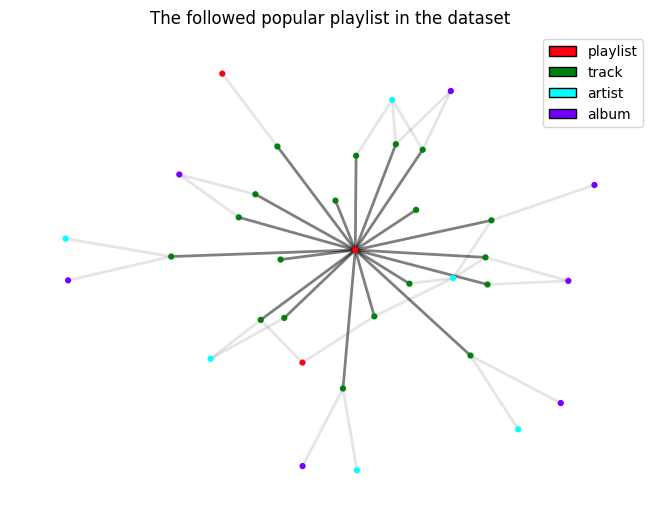

In [290]:
popular_playlist = max([(key, data) for key, data in G.nodes(data=True) if data['node_type'] == 'playlist'], key=lambda x: x[1]['num_followers']) # this is a (id, node_attr) tuple
draw_subgraph_from_start(G, popular_playlist[0], 2, "The followed popular playlist in the dataset")

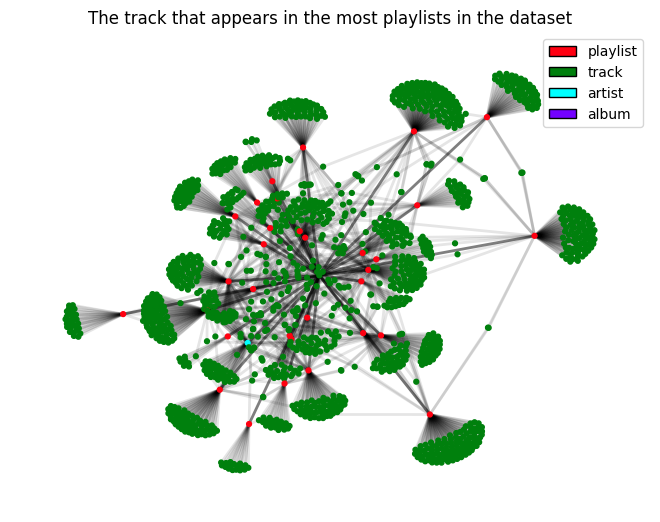

In [291]:
popular_playlist = max([(key, data) for key, data in G.nodes(data=True) if data['node_type'] == 'track'], key=lambda x: len(G.adj[x[0]])) # this is a (id, node_attr) tuple
draw_subgraph_from_start(G, popular_playlist[0],2,"The track that appears in the most playlists in the dataset")

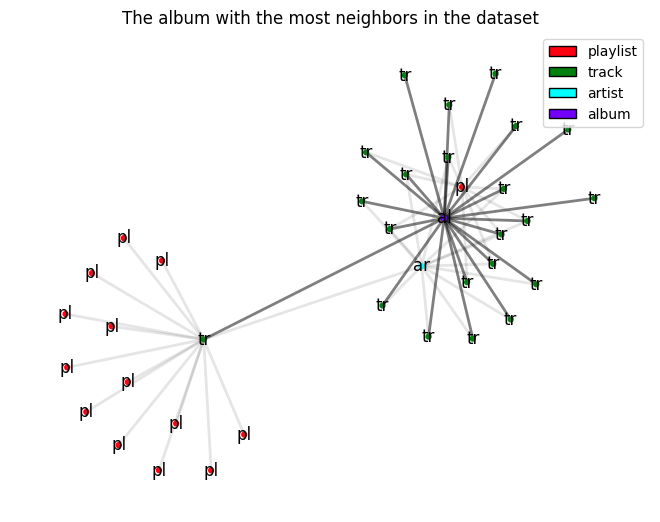

In [292]:
popular_playlist = max([(key, data) for key, data in G.nodes(data=True) if data['node_type'] == 'album'], key=lambda x: len(G.adj[x[0]])) # this is a (id, node_attr) tuple
draw_subgraph_from_start(G, popular_playlist[0], 2, "The album with the most neighbors in the dataset", True)